# Notebook content


    1.   Dataset Overview
    2.   Data Loading and Exploration
    3.   Preparing Data
    4.   Building Models





## **1.   Dataset Overview**

**NIH Chest X-rays** : is a large collection of chest X-ray images that was made publicly available by the National Institutes of Health (NIH). This data is used to predict the tumor type from 14 types we have
- **Atelectasis**
- **Cardiomegaly** 
- **Effusion**
- **Infiltration**
- **Mass**
- **Nodule**
- **Pneumonia**
- **Pneumothorax**
- **Consolidation**
- **Edema**
- **Emphysema**
- **Fibrosis**
- **Pleural_Thickening**
- **Hernia** 

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For plotting and visualizations
from matplotlib import gridspec
%matplotlib inline 
from tqdm import tqdm
from cv2 import imread, createCLAHE
import cv2
import seaborn as sns  # For enhanced data visualization
import os  # For interacting with the operating system
import pydicom  # For working with DICOM medical imaging files
from glob import glob  # For finding file paths matching a pattern
from PIL import Image  # For image processing and manipulation
import random  # For generating random numbers and selections
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets
import pickle  # For serializing and deserializing Python objects
from itertools import chain  # For chaining iterables together
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting image data for training
from keras.applications.mobilenet import MobileNet  # For importing the MobileNet model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten  # For defining layers in a neural network
from keras.models import Sequential  # For creating sequential models
from keras import optimizers, callbacks, regularizers  # For optimization, callbacks, and regularization functions
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau  # For defining various callbacks
from keras import optimizers  # For optimization algorithms
from keras.callbacks import EarlyStopping, ModelCheckpoint  # For early stopping and saving the best model

## **2.   Data Loading and Exploration**

In [2]:
# Read CSV file into a pandas DataFrame
data_csv = pd.read_csv('Data_Entry_2017.csv')

In [3]:
print(f"Number of rows in the dataset: {data_csv.shape[0]}")
print(f"Number of columns in the dataset: {data_csv.shape[1]}")
data_csv.head()

Number of rows in the dataset: 112120
Number of columns in the dataset: 12


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

#### For training reasons, we try to reduce the size of the dataset

In [4]:
# Create a dictionary of image paths with filenames as keys and full paths as values
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('D:/', 'Dataset','*.png'))}

# Print the number of scans found and the total number of rows in data_csv
print('Scans found:', len(all_image_paths), ', Total Headers', data_csv.shape[0])

# Map image paths to the 'Image Index' column in data_csv and create a new 'path' column
data_csv['path'] = data_csv['Image Index'].map(all_image_paths.get)

# Display a sample of 3 rows from the updated DataFrame
data_csv.sample(3)


Scans found: 7730 , Total Headers 112120


Image Index                    Finding Labels  Follow-up #  \
70534  00017402_004.png                       Atelectasis            4   
52993  00013370_001.png  Consolidation|Edema|Infiltration            1   
35963  00009487_005.png                        No Finding            5   

       Patient ID  Patient Age Patient Gender View Position  \
70534       17402           28              M            PA   
52993       13370           62              M            AP   
35963        9487           46              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
70534                 2992     2991                        0.143  0.143   
52993                 2500     2048                        0.168  0.168   
35963                 2992     2991                        0.143  0.143   

       Unnamed: 11  path  
70534          NaN  None  
52993          NaN  None  
35963          NaN  None

### As we are going to use just 8 classes or types, we will remove the others

In [5]:
# Remove specific labels from the 'Finding Labels' column
labels_to_remove = ['Hernia', 'Emphysema', 'Fibrosis', 'Edema', 'Pleural_Thickening', 'Consolidation']
for label in labels_to_remove:
    data_csv['Finding Labels'] = data_csv['Finding Labels'].map(lambda x: x.replace(label, ''))

# Extract unique labels remaining in 'Finding Labels'
all_labels = np.unique(list(chain(*data_csv['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Add binary columns for each unique label
for c_label in all_labels:
    data_csv[c_label] = data_csv['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# Display a sample of 3 rows from the updated DataFrame
data_csv.sample(3)

All Labels (9): ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pneumonia', 'Pneumothorax']


Image Index                  Finding Labels  Follow-up #  \
47741   00012094_058.png                                           58   
107578  00029058_002.png                      No Finding            2   
85909   00021201_019.png  Atelectasis|Effusion|Pneumonia           19   

        Patient ID  Patient Age Patient Gender View Position  \
47741        12094           63              F            AP   
107578       29058           30              M            PA   
85909        21201           65              M            AP   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  path  \
47741                  2500     2048                     0.168000  ...  None   
107578                 2021     2021                     0.194311  ...  None   
85909                  3056     2544                     0.139000  ...  None   

        Atelectasis Cardiomegaly  Effusion  Infiltration  Mass  No Finding  \
47741           0.0          0.0       0.0           0.0   0.0         0.0   
107578          0.0          0.0       0.0           0.0   0.0         1.0   
85909           1.0          0.0       1.0           0.0   0.0         0.0   

        Nodule  Pneumonia  Pneumothorax  
47741      0.0        0.0           0.0  
107578     0.0        0.0           0.0  
85909      0.0        1.0           0.0  

[3 rows x 22 columns]

In [6]:
#find the columns of the dataset
data_csv.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

### The main CSV file **'Data_Entry_2017.csv'** contains information about the entire dataset. We'll generate a specific CSV file for our subset.

In [7]:
# Paths to the input files
large_csv_path = 'Data_Entry_2017.csv'
image_dir_path = 'D:/Dataset/'
output_csv_path = 'subset_csv_file.csv'

# Read the large CSV file
large_df = data_csv

# Get the list of image names from the directory
image_names = [f for f in os.listdir(image_dir_path) if os.path.isfile(os.path.join(image_dir_path, f))]

# Filter the large DataFrame to include only the rows with image names in the list
filtered_df = large_df[large_df['Image Index'].isin(image_names)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv(output_csv_path, index=False)

print(f"Filtered CSV file saved to {output_csv_path}")


Filtered CSV file saved to subset_csv_file.csv


In [8]:
# Read CSV file into a pandas DataFrame
data_csv=pd.read_csv("subset_csv_file.csv")

In [9]:
# Find the size of the csv
data_csv.shape

(7730, 22)

In [10]:
# Read the first 5 lines from the subset csv
data_csv.head()

Image Index               Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png                 Cardiomegaly            0           1   
1  00000001_001.png                Cardiomegaly|            1           1   
2  00000001_002.png        Cardiomegaly|Effusion            2           1   
3  00000013_005.png  |Infiltration||Pneumothorax            5          13   
4  00000013_006.png        Effusion|Infiltration            6          13   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           60              M            AP                 3056     2544   
4           60              M            AP                 3056     2544   

   OriginalImagePixelSpacing[x  ...                         path  Atelectasis  \
0                        0.143  ...  D:/Dataset\00000001_000.png          0.0   
1                        0.143  ...  D:/Dataset\00000001_001.png          0.0   
2                        0.168  ...  D:/Dataset\00000001_002.png          0.0   
3                        0.139  ...  D:/Dataset\00000013_005.png          0.0   
4                        0.139  ...  D:/Dataset\00000013_006.png          0.0   

  Cardiomegaly  Effusion  Infiltration  Mass  No Finding  Nodule  Pneumonia  \
0          1.0       0.0           0.0   0.0         0.0     0.0        0.0   
1          1.0       0.0           0.0   0.0         0.0     0.0        0.0   
2          1.0       1.0           0.0   0.0         0.0     0.0        0.0   
3          0.0       0.0           1.0   0.0         0.0     0.0        0.0   
4          0.0       1.0           1.0   0.0         0.0     0.0        0.0   

   Pneumothorax  
0           0.0  
1           0.0  
2           0.0  
3           1.0  
4           0.0  

[5 rows x 22 columns]

In [11]:
# Drop unnecessary column
data_csv=data_csv.drop(columns=["Unnamed: 11"])

In [12]:
# Check if there is some missing values
missing_values = data_csv.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [13]:
# Display concise summary of the DataFrame
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  7730 non-null   object 
 1   Finding Labels               7730 non-null   object 
 2   Follow-up #                  7730 non-null   int64  
 3   Patient ID                   7730 non-null   int64  
 4   Patient Age                  7730 non-null   int64  
 5   Patient Gender               7730 non-null   object 
 6   View Position                7730 non-null   object 
 7   OriginalImage[Width          7730 non-null   int64  
 8   Height]                      7730 non-null   int64  
 9   OriginalImagePixelSpacing[x  7730 non-null   float64
 10  y]                           7730 non-null   float64
 11  path                         7730 non-null   object 
 12  Atelectasis                  7730 non-null   float64
 13  Cardiomegaly      

In [14]:
data_csv.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [15]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
ax = sns.histplot(data_csv['Patient Age'], bins=30, kde=True)

# Set x-axis limits
ax.set_xlim(0, 100)

# Add title and labels
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Display plot
plt.show()


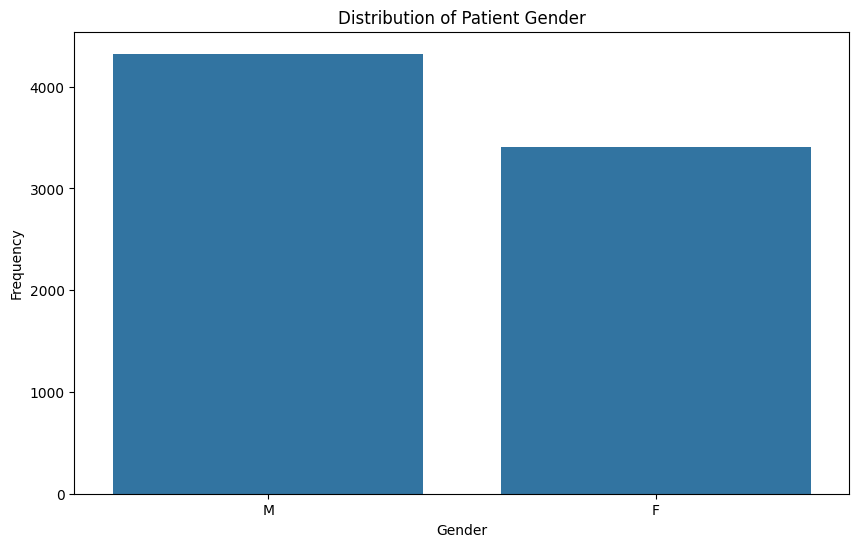

In [16]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot count plot for patient gender
sns.countplot(x='Patient Gender', data=data_csv)

# Add title and labels
plt.title('Distribution of Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')

# Display plot
plt.show()

In [17]:
# Compute disease counts
disease_counts = data_csv['Finding Labels'].str.split('|').explode().value_counts()

# Set figure size
plt.figure(figsize=(15, 8))

# Plot bar plot
sns.barplot(x=disease_counts.index, y=disease_counts.values)

# Add title and labels
plt.title('Distribution of Diseases')
plt.xlabel('Disease')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display plot
plt.show()

In [18]:
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

data_dir = 'D:/Dataset/'

image_paths = glob(os.path.join(data_dir, '*.png'))  # Update path if necessary

def display_random_images(image_paths, data_csv, num_images):
    selected_images = random.sample(image_paths, num_images)
    plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(selected_images):
        img = Image.open(image_path)
        img_array = np.array(img)
        
        # Display the image
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img_array, cmap='gray')
        image_name = os.path.basename(image_path)
        label = data_csv[data_csv['Image Index'] == image_name]['Finding Labels'].values[0]
        plt.title(f"Label: {label}")
        plt.axis('off')
        
        # Display the histogram
        plt.subplot(num_images, 2, 2*i+2)
        plt.hist(img_array.ravel(), bins=256, color='gray', alpha=0.75)
        plt.title("Histogram")
        plt.xlabel("Pixel value")
        plt.ylabel("Frequency")
        plt.grid(False)
    
    plt.tight_layout()
    plt.show()

In [19]:
display_random_images(image_paths, data_csv, 5)

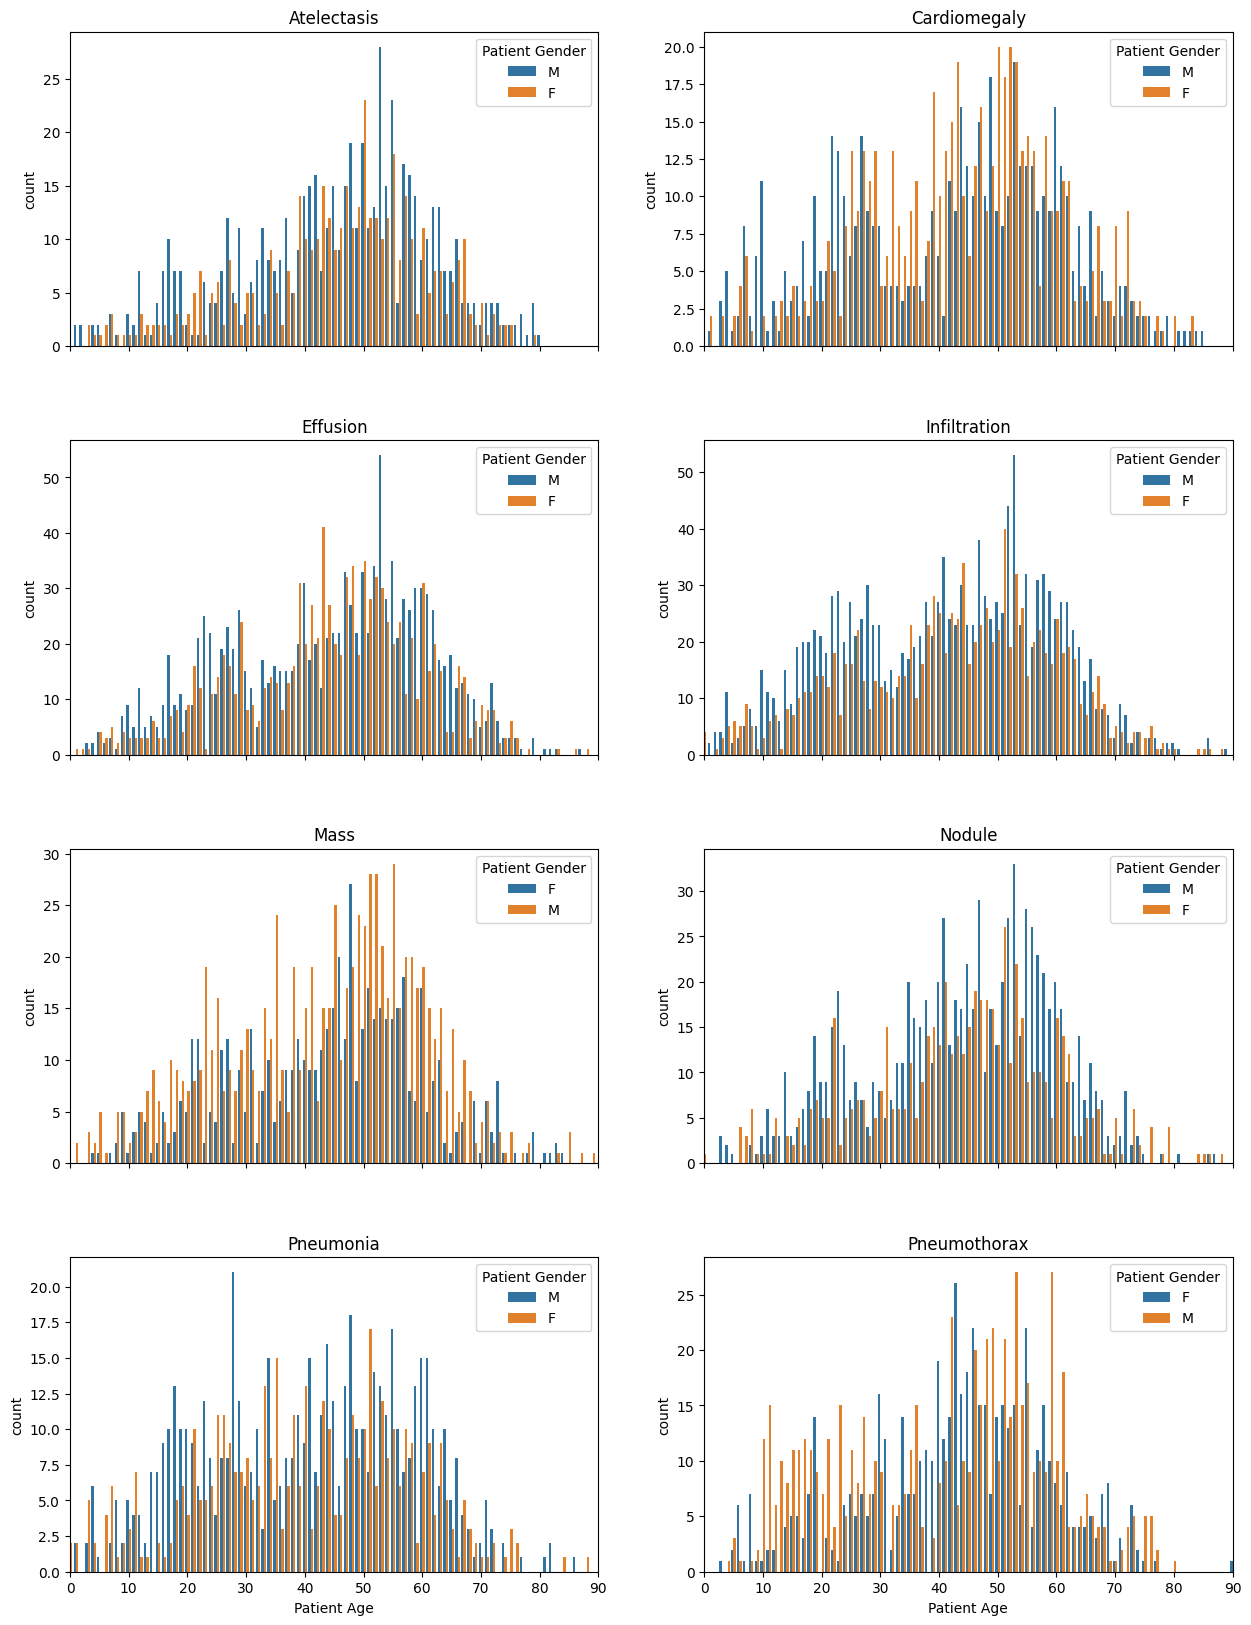

In [20]:
# Define list of pathologies
pathology_list = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

# Copy DataFrame (if needed)
df = data_csv.copy()

# Create subplots grid
f, axarr = plt.subplots(4, 2, sharex=True, figsize=(15, 20))

# Initialize subplot indices
i, j = 0, 0

# Define x-axis ticks
x = np.arange(0, 100, 10)

# Iterate through each pathology
for pathology in pathology_list:
    # Filter data for current pathology
    pathology_df = df[df['Finding Labels'].str.contains(pathology)]
    
    # Create count plot
    g = sns.countplot(x='Patient Age', hue='Patient Gender', data=pathology_df, ax=axarr[i, j])
    
    # Set title for subplot
    axarr[i, j].set_title(pathology)
    
    # Set x-axis limits and ticks
    g.set_xlim(0, 90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    
    # Update subplot indices
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 7

# Adjust subplot layout
f.subplots_adjust(hspace=0.3)

# Display the plot
plt.show()

In [21]:
for pathology in pathology_list :
    data_csv[pathology] = data_csv['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

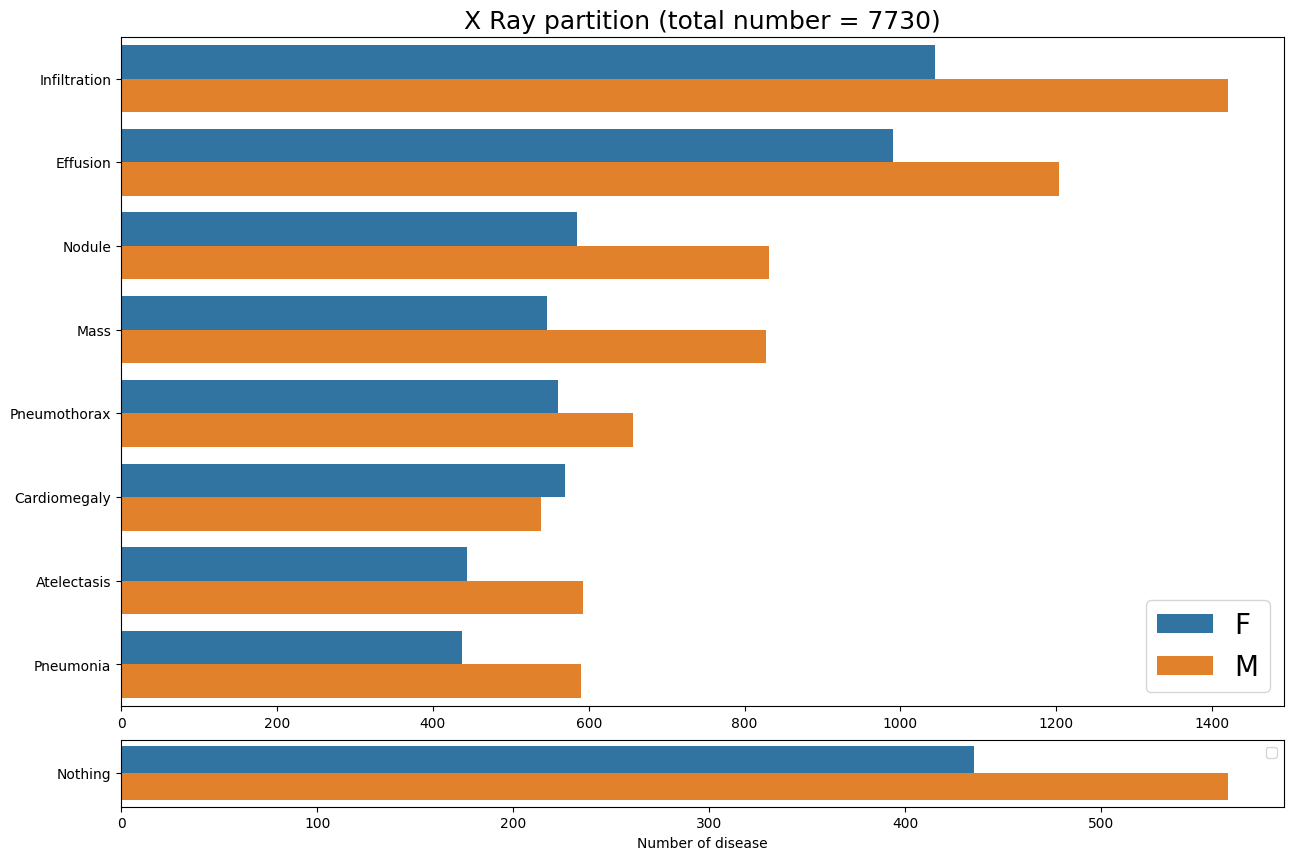

In [22]:
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(8, 1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])

# Melt the data for the pathology count plot
data1 = pd.melt(data_csv,
                id_vars=['Patient Gender'],
                value_vars=pathology_list,
                var_name='Category',
                value_name='Count')
data1 = data1.loc[data1.Count > 0]

# Plot the pathology count by gender
g = sns.countplot(y='Category', hue='Patient Gender', data=data1, ax=ax1,
                  order=data1['Category'].value_counts().index)
ax1.set(ylabel="", xlabel="")
ax1.legend(fontsize=20)
ax1.set_title(f'X Ray partition (total number = {data_csv.shape[0]})', fontsize=18)

# Add a new column 'Nothing' to indicate 'No Finding'
data_csv['Nothing'] = data_csv['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

# Melt the data for the 'No Finding' count plot
data2 = pd.melt(data_csv,
                id_vars=['Patient Gender'],
                value_vars=['Nothing'],
                var_name='Category',
                value_name='Count')
data2 = data2.loc[data2.Count > 0]

# Plot the 'No Finding' count by gender
g = sns.countplot(y='Category', hue='Patient Gender', data=data2, ax=ax2)
ax2.set(ylabel="", xlabel="Number of disease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)
plt.show()

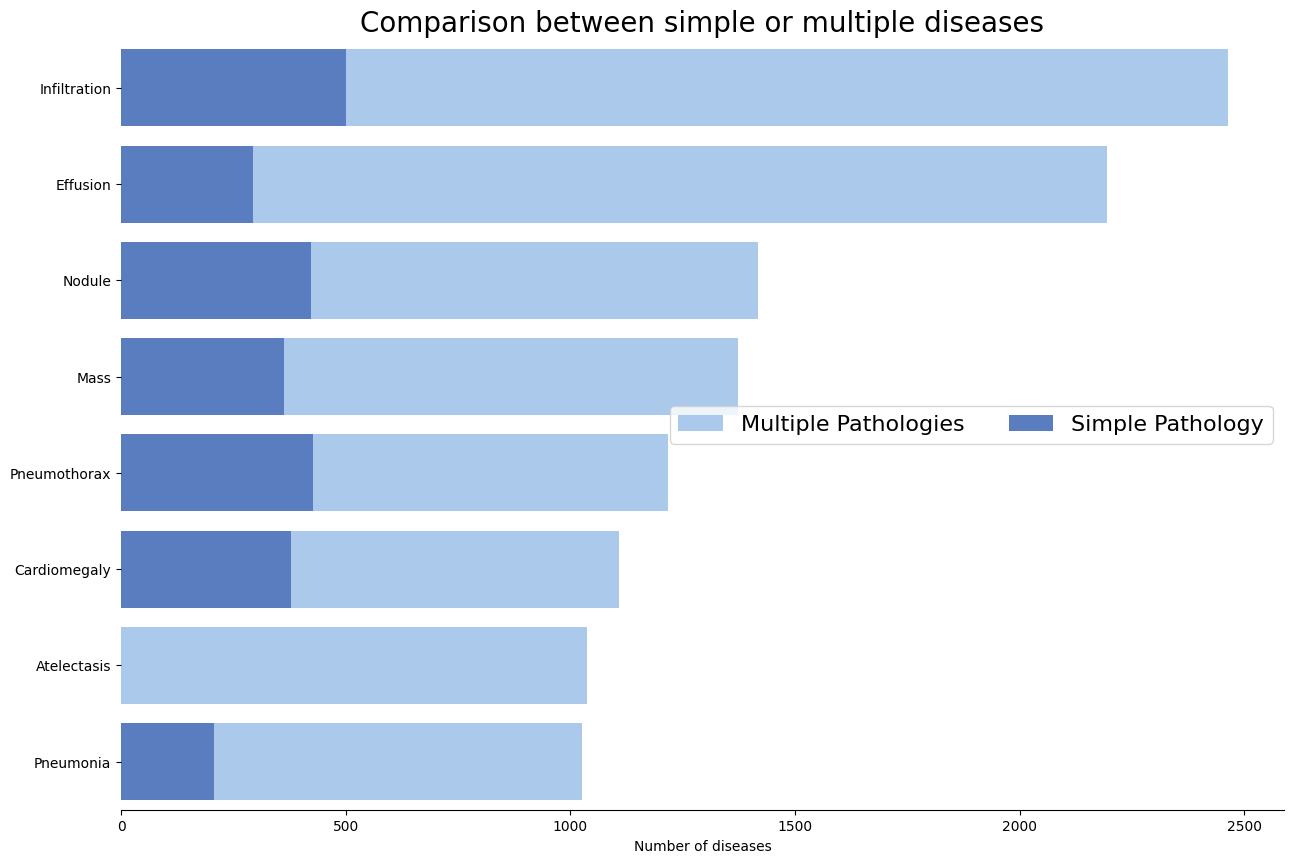

In [25]:
for pathology in pathology_list:
    data_csv[pathology] = data_csv['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

# Add a new column 'Multiple Pathologies' indicating whether a patient has more than one pathology
data_csv['Multiple Pathologies'] = data_csv[pathology_list].sum(axis=1) > 1

# Group data by finding labels and sort by the number of patients
df = data_csv.groupby('Finding Labels').count().sort_values('Patient ID', ascending=False)

# Separate data into multiple and single pathology groups
df1 = df[['|' in index for index in df.index]].copy()
df2 = df[['|' not in index for index in df.index]]
df2 = df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels'] = df2.index.values
df1['Finding Labels'] = df1.index.values

# Melt the data for multiple pathologies
data1 = pd.melt(data_csv,
                id_vars=['Patient Gender'],
                value_vars=pathology_list,
                var_name='Category',
                value_name='Count')
data1 = data1.loc[data1.Count > 0]

# Create the figure and subplots
f, ax = plt.subplots(sharex=True, figsize=(15, 10))

# Set color codes for the plots
sns.set_color_codes("pastel")

# Plot the count of multiple pathologies by category
g = sns.countplot(y='Category', data=data1, ax=ax, order=data1['Category'].value_counts().index, color='b', label="Multiple Pathologies")

# Set muted color codes for the second plot
sns.set_color_codes("muted")

# Prepare data for simple pathology barplot
simple_pathology_counts = df2[['Patient ID', 'Finding Labels']].copy()

# Plot the count of simple pathologies
g = sns.barplot(x='Patient ID', y='Finding Labels', data=simple_pathology_counts, ax=ax, color="b", label="Simple Pathology")

# Customize the plot
ax.legend(ncol=3, loc="center right", frameon=True, fontsize=16)
ax.set(ylabel="", xlabel="Number of diseases")
ax.set_title("Comparison between simple or multiple diseases", fontsize=20)
sns.despine(left=True)

plt.show()

In [26]:
# Filter rows based on condition and select relevant columns
df3 = df1.loc[df1['Patient ID'] > 30, ['Patient ID', 'Finding Labels']].copy()

# Initialize columns for each pathology with default value 0
for pathology in pathology_list:
    df3[pathology] = 0

# Function to check if pathology is in Finding Labels and set corresponding Patient ID
def set_pathology_value(row, pathology):
    if pathology in row['Finding Labels']:
        return row['Patient ID']
    else:
        return 0

# Apply function row-wise to set values in each pathology column
for pathology in pathology_list:
    df3[pathology] = df3.apply(lambda row: set_pathology_value(row, pathology), axis=1)

# Display the first few rows of the updated DataFrame
df3.head()

Patient ID          Finding Labels  Atelectasis  \
Finding Labels                                                            
Cardiomegaly|Effusion          202   Cardiomegaly|Effusion            0   
Effusion|Infiltration          190   Effusion|Infiltration            0   
Infiltration|Nodule            189     Infiltration|Nodule            0   
Infiltration|Pneumonia         145  Infiltration|Pneumonia            0   
Mass|Nodule                    122             Mass|Nodule            0   

                        Cardiomegaly  Effusion  Infiltration  Mass  Nodule  \
Finding Labels                                                               
Cardiomegaly|Effusion            202       202             0     0       0   
Effusion|Infiltration              0       190           190     0       0   
Infiltration|Nodule                0         0           189     0     189   
Infiltration|Pneumonia             0         0           145     0       0   
Mass|Nodule                        0         0             0   122     122   

                        Pneumonia  Pneumothorax  
Finding Labels                                   
Cardiomegaly|Effusion           0             0  
Effusion|Infiltration           0             0  
Infiltration|Nodule             0             0  
Infiltration|Pneumonia        145             0  
Mass|Nodule                     0             0

In [27]:
# Print all the labels
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

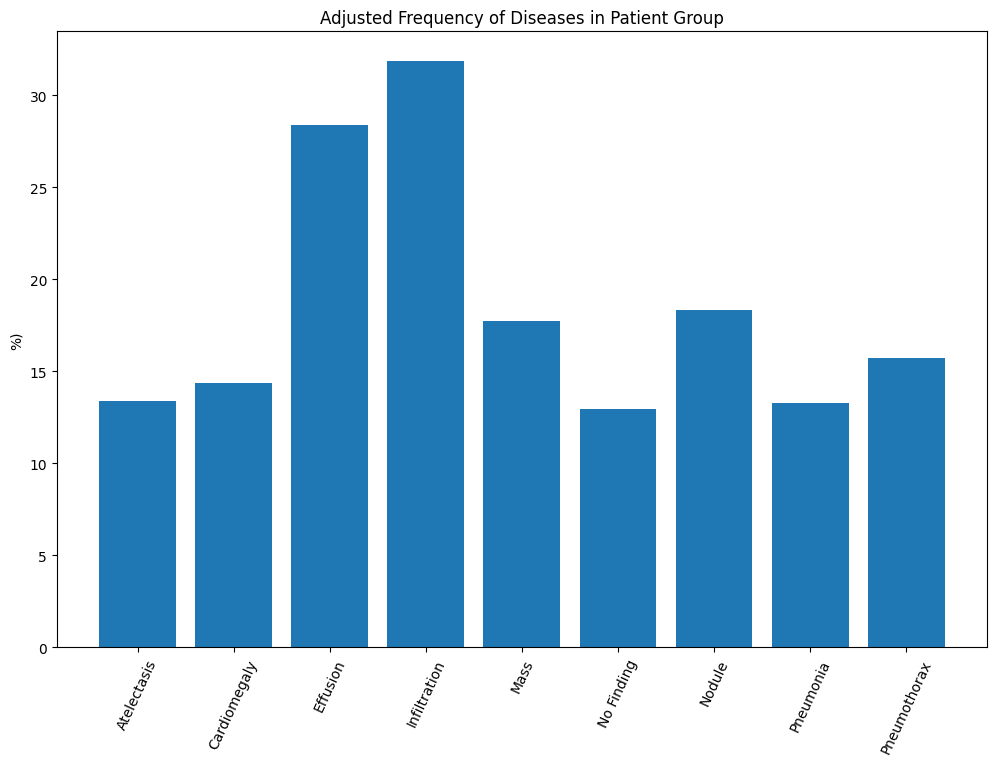

In [28]:
# Calculate adjusted frequency of diseases in patient group
label_counts = 100 * np.mean(data_csv[all_labels].values, axis=0)

# Create figure and axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Plot bar chart
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)

# Set x-axis ticks and labels
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
ax1.set_xticklabels(all_labels, rotation=65)

# Set title and y-axis label
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('%)')

# Display the plot
plt.show()

In [29]:
# Create a new column 'disease_vec' in data_csv
# Assign lists containing binary values for each row, representing presence or absence of each disease label
data_csv['disease_vec'] = data_csv.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

### Now we are going to split our dataset into train set and validation set

In [30]:
# Calculate the counts of each unique combination of finding labels
class_counts = data_csv['Finding Labels'].value_counts()

# Filter the dataset to include only rows where each unique combination appears at least twice
filtered_data_csv = data_csv[data_csv['Finding Labels'].map(class_counts) >= 2]

# Split the filtered dataset into training and validation sets
train_df, valid_df = train_test_split(filtered_data_csv, 
                                      test_size=0.1, 
                                      random_state=2018, 
                                      stratify=filtered_data_csv['Finding Labels'])

# Print the number of instances in the training and validation sets
print('Training set:', train_df.shape[0], 'instances')
print('Validation set:', valid_df.shape[0], 'instances')

Training set: 6812 instances
Validation set: 757 instances


## **3.   Preparing Data**

### In this step, we are going to prepare our data for training by applying some tasks
### - **Normalization**
### - **Equalized Histogram**
### - **CLAHE**

In [31]:
# Function to normalize the image
def normalize_image(image):
    normalized_img = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return (normalized_img * 255).astype(np.uint8)

# Function to apply histogram equalization
def equalize_histogram(image):
    if len(image.shape) == 3 and image.shape[2] == 3:  # If the image is colored (3 channels)
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        equalized_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:  # If the image is grayscale (1 channel)
        equalized_img = cv2.equalizeHist(image)
    return equalized_img

# Function to apply CLAHE
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 3 and image.shape[2] == 3:  # If the image is colored (3 channels)
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        clahe_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:  # If the image is grayscale (1 channel)
        clahe_img = clahe.apply(image)
    return clahe_img

# Function to preprocess the image
def preprocess_image(image):
    # Normalization
    normalized_img = normalize_image(image)

    # Histogram Equalization
    equalized_img = equalize_histogram(normalized_img)

    # CLAHE
    clahe_img = apply_clahe(equalized_img)

    return clahe_img

# Function to process all images in a directory
def process_images_in_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                processed_image = preprocess_image(image)
                output_path = os.path.join(output_dir, filename)
                cv2.imwrite(output_path, processed_image)
                print(f"Processed and saved: {filename}")

# Example usage
input_directory = 'D:/Dataset'
output_directory = 'D:/Dataset_processed'
process_images_in_directory(input_directory, output_directory)


Processed and saved: 00000001_000.png
Processed and saved: 00000001_001.png
Processed and saved: 00000001_002.png
Processed and saved: 00000013_005.png
Processed and saved: 00000013_006.png
Processed and saved: 00000013_011.png
Processed and saved: 00000013_022.png
Processed and saved: 00000013_026.png
Processed and saved: 00000013_031.png
Processed and saved: 00000013_037.png
Processed and saved: 00000013_039.png
Processed and saved: 00000013_040.png
Processed and saved: 00000013_045.png
Processed and saved: 00000029_000.png
Processed and saved: 00000032_002.png
Processed and saved: 00000032_004.png
Processed and saved: 00000032_006.png
Processed and saved: 00000032_007.png
Processed and saved: 00000032_029.png
Processed and saved: 00000032_031.png
Processed and saved: 00000032_032.png
Processed and saved: 00000032_045.png
Processed and saved: 00000032_055.png
Processed and saved: 00000033_000.png
Processed and saved: 00000035_000.png
Processed and saved: 00000040_003.png
Processed an

## **4.   Building Models**

In this phase, we will commence building and training our models, focusing on three types
1.   Segmentation model : **U-net**
2.   Detection & Classification model : **ResNet50**

#### **Segmentation : U-net**

Our dataset lacks masks for each image. Therefore, we opted to utilize a simplified dataset comprising 800 X-ray images paired with their corresponding masks. This dataset will serve as input for our **U-net** model.

In [75]:
# Set the paths
image_path = os.path.join("D:/Dataset/ds/CXR_png")
mask_path = os.path.join("D:/Dataset/ds/masks")

In [76]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
#print(images)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [77]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [35]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        print(np.shape(im_array),np.shape(mask_array))
        return im_array,mask_array

In [78]:
def plotMask(X, y):
    sample = []

    # Combine each pair of images and masks horizontally
    for i in range(6):
        left = X[i]  # Image
        right = y[i]  # Mask
        combined = np.hstack((left, right))  # Combine image and mask side by side
        sample.append(combined)  # Append to sample list

    # Plotting the combined images and masks in sets of three
    for i in range(0, 6, 3):
        plt.figure(figsize=(25, 10))  # Set figure size

        # Plot the first image-mask pair
        plt.subplot(2, 3, 1 + i)
        plt.imshow(sample[i])
        plt.title(f'Sample {i+1}')

        # Plot the second image-mask pair
        plt.subplot(2, 3, 2 + i)
        plt.imshow(sample[i + 1])
        plt.title(f'Sample {i+2}')

        # Plot the third image-mask pair
        plt.subplot(2, 3, 3 + i)
        plt.imshow(sample[i + 2])
        plt.title(f'Sample {i+3}')

        plt.show()  # Display the plot

In [79]:
# Load data
dim = 128
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 566/566 [01:39<00:00,  5.69it/s]


(566, 128, 128) (566, 128, 128)


100%|██████████| 138/138 [00:53<00:00,  2.59it/s]


training set


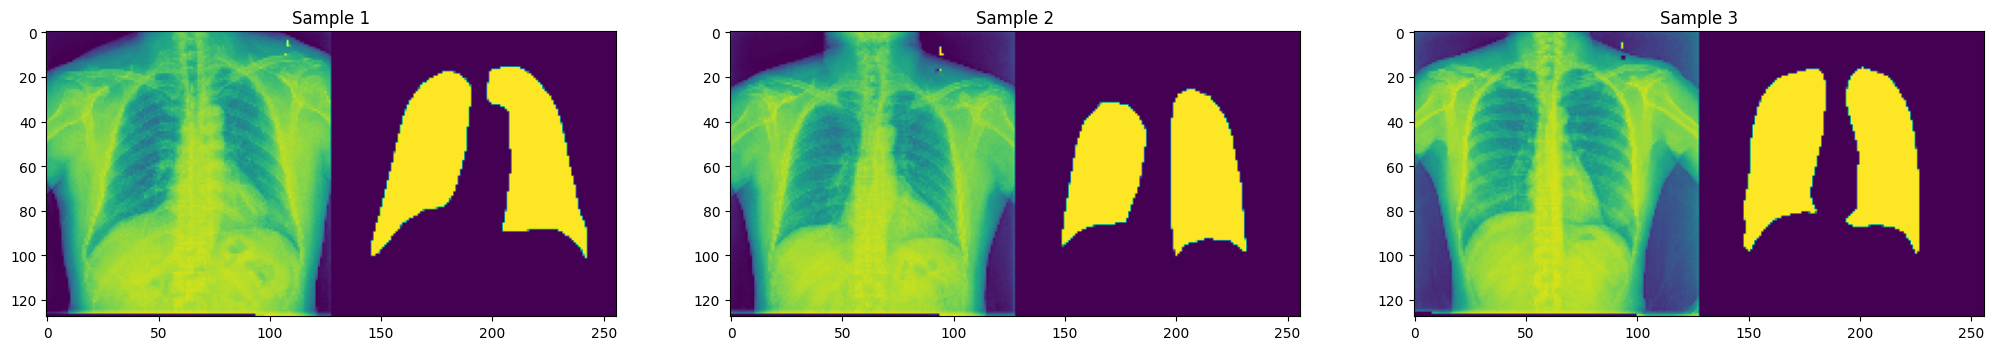

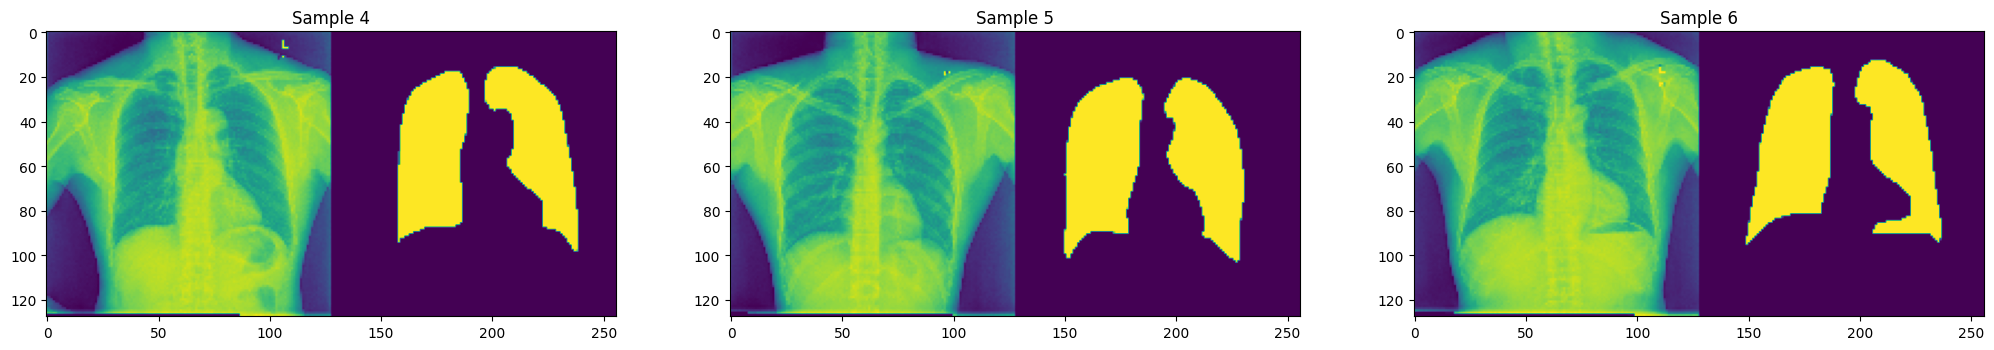

testing set


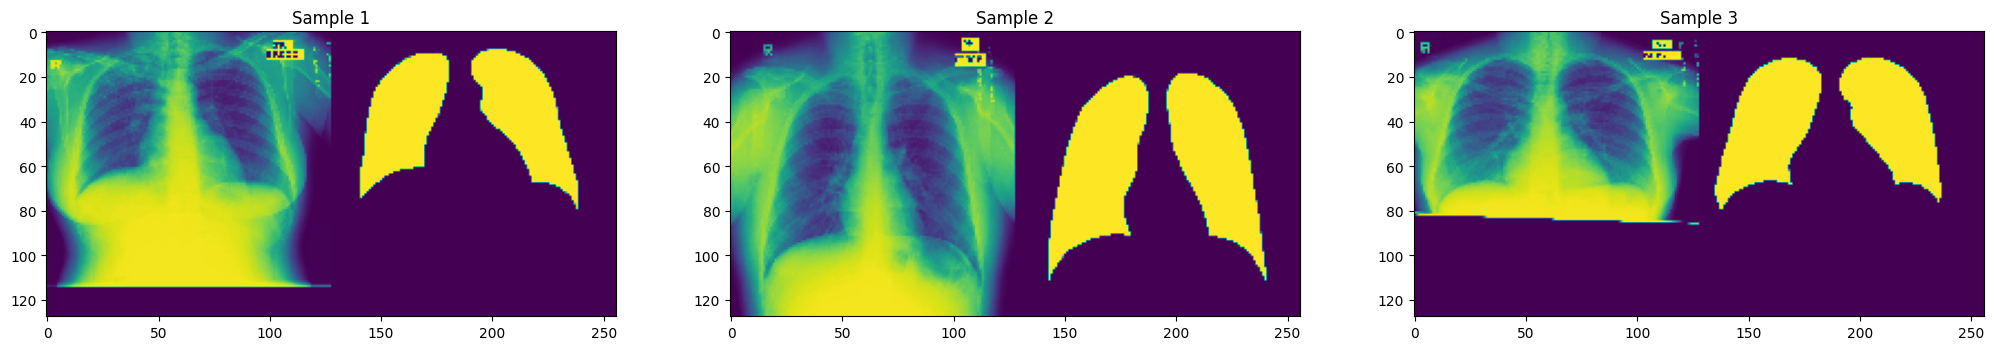

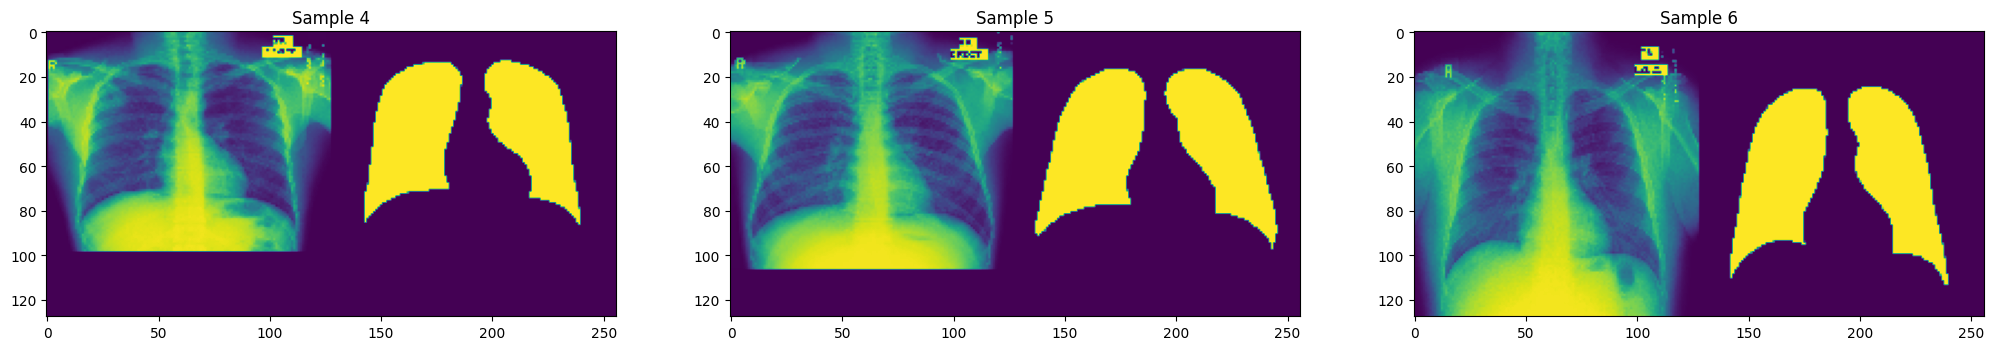

In [80]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [81]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [82]:
print(np.shape(images))

(704, 128, 128, 1)


In [83]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(128,128,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [84]:
model = unet(input_size=(128,128,1))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 256) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │    524,544 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import load_model

# Define the custom objects for loading the model
# custom_objects = {'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef}

model_path = 'model/unet_model.keras'
# Load the model in the native Keras format
model = load_model(model_path, compile=False)


In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)  # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [86]:
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                                        (mask>127).astype(np.float32),
                                                                        test_size=0.1, random_state=2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol, train_seg,
                                                            test_size=0.01,
                                                            random_state=2018)

loss_history = model.fit(x=train_vol,
                         y=train_seg,
                         batch_size=32,
                         epochs=50,
                         validation_data=(test_vol, test_seg),
                         callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.2797 - dice_coef: 0.3392 - loss: -0.3391
Epoch 1: val_loss improved from inf to -0.39732, saving model to cxr_reg_weights.best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - binary_accuracy: 0.2792 - dice_coef: 0.3395 - loss: -0.3394 - val_binary_accuracy: 0.2428 - val_dice_coef: 0.3973 - val_loss: -0.3973 - learning_rate: 2.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.2619 - dice_coef: 0.4111 - loss: -0.4111
Epoch 2: val_loss improved from -0.39732 to -0.40103, saving model to cxr_reg_weights.best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - binary_accuracy: 0.2639 - dice_coef: 0.4107 - loss: -0.4107 - val_binary_accuracy: 0.3029 - val_dice_coef: 0.4010 - val_loss: -0.4010 - learning_rate: 2.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.3044 - dice_coef: 0.4277 - loss: -0.4276
Epoch 3: val_loss improved from -0.40103 to -0.48873, saving m

In [87]:
# Save the model
model_path = 'model/U-net_model.keras'
save_model(model, model_path)

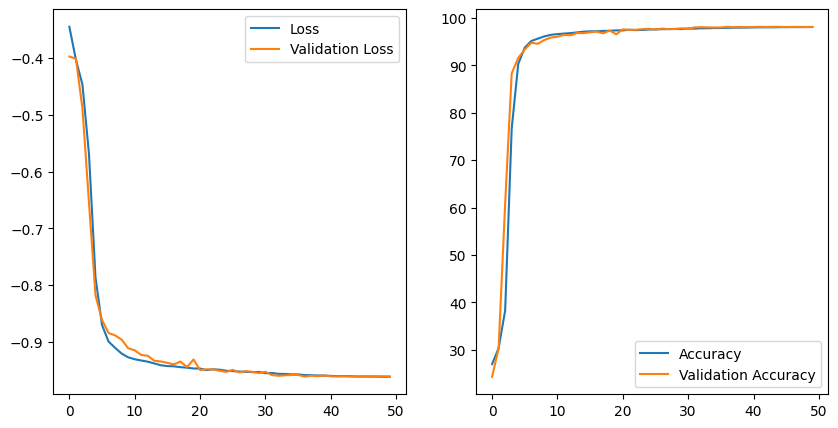

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-',
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [89]:
Test_dir = 'D:/Dataset/'

In [90]:
test = []
for f in tqdm(os.listdir(Test_dir)):
    file_path = os.path.join(Test_dir, f)
    im = cv2.imread(file_path)

    if im is None:
        print(f"Failed to read image: {file_path}")
        continue

    im = cv2.resize(im, (128, 128))
    im = im[:, :, 0]
    im = im.reshape(128, 128, 1)
    test.append(im)

print(np.array(test).shape)


100%|██████████| 7731/7731 [02:25<00:00, 53.28it/s]


Failed to read image: D:/Dataset/ds
(7730, 128, 128, 1)


In [91]:
import gc
gc.collect()

3442

In [92]:
def mode_prediction(start,end,arr):
    tval = []
    for tpost in tqdm(range(start,end)):
        nval = test[tpost]
        val = (nval-127.0)/127.0
        tval.append(val)
    return tval

In [93]:
predictions = []
pending, batch = 0,1546
count = len(test)
start= 0
sum = 0
while(count>=0):
    end = start+batch
    sum = start-end
    if(end<len(test)):
        predictions.append(mode_prediction(start,end,test))
        start = end
    else:
        predictions.append(mode_prediction(start,len(test),test))
        start = end
        break
    count = count-sum
    gc.collect()

print(np.shape(predictions))

100%|██████████| 1546/1546 [00:00<00:00, 6665.81it/s]


(5, 1546, 128, 128, 1)


In [94]:
final_vals = []
for k in predictions:
    for r in k:
        final_vals.append(r)
print(np.shape(final_vals))

(7730, 128, 128, 1)


In [95]:
final_preds = model.predict(np.array(final_vals))

242/242 ━━━━━━━━━━━━━━━━━━━━ 187s 768ms/step


In [ ]:
image="D:/Dataset/00000001_000.png"
# img=cv2.resize(image, (128, 128))
# image = cv2.imread(img)

In [ ]:
image=model.evaluate()

In [96]:
import os
import cv2
import numpy as np

# Assuming you have the following variables
# loaded_model: your loaded U-Net model
# images_dir: directory containing image files
# save_path: path to save the generated masks

images_dir = "D:/Dataset_processed/"
save_path = "D:/Generated_mask"

# Get list of all image file paths in the directory
image_paths = [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

for image_path in image_paths:
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue
    
    # Resize the image to the expected input size of the model (128x128)
    image = cv2.resize(image, (128, 128))
    
    # Convert the image to grayscale if the model expects single-channel input
    if model.input_shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalize the image if required by your model (e.g., scaling pixel values)
    image = image / 255.0
    
    # Predict the mask
    mask = model.predict(np.expand_dims(image, axis=0))[0]
    
    # Postprocess the mask if necessary (thresholding, resizing back to original size, etc.)
    # In this case, we assume the mask is already the correct size and only needs scaling
    mask = (mask > 0.5).astype(np.uint8)  # Example thresholding, adjust as needed
    
    # Create the mask filename
    base_name = os.path.basename(image_path)
    mask_name = os.path.splitext(base_name)[0] + ".png"
    
    # Save the mask
    cv2.imwrite(os.path.join(save_path, mask_name), mask * 255)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

In [97]:
import json

def load_annotations(json_path):
    with open(json_path, 'r') as file:
        annotations = json.load(file)
    return annotations

annotations = load_annotations('annotations-128.json')

In [98]:
import os
import numpy as np

def extract_data(annotations, images_dir):
    image_paths = []
    bboxes = []
    labels = []
    categories = {cat['id']: cat['name'] for cat in annotations['categories']}

    image_id_to_file = {img['id']: img['file_name'] for img in annotations['images']}
    
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        image_path = os.path.join(images_dir, image_id_to_file[image_id])
        bbox = ann['bbox']
        label = ann['category_id']
        
        image_paths.append(image_path)
        bboxes.append(bbox)
        labels.append(label)
    
    return np.array(image_paths), np.array(bboxes), np.array(labels), categories

images_dir = 'D:/DETECT_TRAIN_SET/'
image_paths, bboxes, labels, categories = extract_data(annotations, images_dir)

In [99]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataGenerator(Sequence):
    def __init__(self, image_paths, bboxes, labels, batch_size=32, image_size=(128, 128), num_classes=9, shuffle=True):
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in indexes]
        batch_bboxes = [self.bboxes[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        
        X, y_class, y_bbox = self.__data_generation(batch_image_paths, batch_bboxes, batch_labels)
        
        return X, {'class_output': y_class, 'bbox_output': y_bbox}

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_bboxes, batch_labels):
        X = np.empty((self.batch_size, *self.image_size, 3))
        y_class = np.empty((self.batch_size, self.num_classes), dtype=int)
        y_bbox = np.empty((self.batch_size, 4), dtype=float)
        
        for i, (img_path, bbox, label) in enumerate(zip(batch_image_paths, batch_bboxes, batch_labels)):
            image = load_img(img_path, target_size=self.image_size)
            image = img_to_array(image) / 255.0

            X[i,] = image
            y_class[i,] = tf.keras.utils.to_categorical(label - 1, num_classes=self.num_classes)
            y_bbox[i,] = bbox
        
        return X, y_class, y_bbox

batch_size = 32
image_size = (128, 128)
num_classes = 9

train_generator = DataGenerator(image_paths, bboxes, labels, batch_size=batch_size, image_size=image_size, num_classes=num_classes)

In [100]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add detection layers
    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    
    # Output layers
    num_classes = 9  # Based on your dataset
    class_output = Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = Dense(4, name='bbox_output')(x)  # [x, y, width, height]
    
    model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    return model

input_shape = (128, 128, 3)
model = create_model(input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 28,359,821 (108.18 MB)

 Trainable params: 28,306,701 (107.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [102]:
# Create and compile the model (assuming you have the create_model function from earlier)
model = create_model(input_shape=(128, 128, 3))
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'binary_accuracy', 'bbox_output': 'mse'})

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=train_generator)  # Assuming you have validation_generator

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - bbox_output_mse: 1086.8369 - class_output_binary_accuracy: 0.8378 - loss: 1091.2947 - val_bbox_output_mse: 527.0825 - val_class_output_binary_accuracy: 0.7968 - val_loss: 531.7508
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - bbox_output_mse: 442.2177 - class_output_binary_accuracy: 0.8757 - loss: 444.6467 - val_bbox_output_mse: 1011.0458 - val_class_output_binary_accuracy: 0.8884 - val_loss: 1013.9607
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - bbox_output_mse: 367.8857 - class_output_binary_accuracy: 0.8735 - loss: 370.2661 - val_bbox_output_mse: 1449.0132 - val_class_output_binary_accuracy: 0.8118 - val_loss: 1451.7480
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - bbox_output_mse: 316.7403 - class_output_binary_accuracy: 0.8770 - loss: 318.8636 - val_bbox_output_mse: 1170.9631 - val_class_output_binary_accuracy: 0.8056 - val_loss: 1174.1307
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - bbox_output_mse: 25

In [103]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Define the preprocess function
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define the predict function
def predict(model, image):
    predictions = model.predict(image)
    class_predictions = predictions[0]  # Assuming the first output is class
    bbox_prediction = predictions[1]  # Assuming the second output is bounding box
    return class_predictions, bbox_prediction

# Define the post-process function
def post_process_prediction(class_predictions, bbox_prediction, categories, original_size, target_size, confidence_threshold=0.5):
    class_id = np.argmax(class_predictions, axis=-1)[0]
    confidence = class_predictions[0, class_id]
    
    if confidence < confidence_threshold:
        return "no finding", [0, 0, 0, 0]
    
    class_label = categories[class_id + 1]  # Adjust for zero-based indexing
    bbox = bbox_prediction[0]
    
    # Rescale bbox to the original image size
    orig_width, orig_height = original_size
    target_width, target_height = target_size
    x_scale = orig_width / target_width
    y_scale = orig_height / target_height
    
    bbox[0] *= x_scale
    bbox[1] *= y_scale
    bbox[2] *= x_scale
    bbox[3] *= y_scale
    
    return class_label, bbox

# Define the display and save function with bounding box
def display_and_save_results(image_path, class_label, bbox, save_dir):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    if class_label != "no finding":
        # Unpack the bounding box coordinates
        x, y, width, height = bbox
        x = int(x)
        y = int(y)
        width = int(width)
        height = int(height)

        # Draw the bounding box
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        cv2.putText(image, class_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    else:
        cv2.putText(image, class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    # Save the image if save_path is provided
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    # Convert the image back to BGR before saving
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, image_bgr)

# Load the trained model
# model_path = 'path/to/your/model.keras'
# model = tf.keras.models.load_model(model_path)

# Define the path to the directory of new images
new_images_dir = 'D:/Dataset/'
save_dir = './Detection_Results'

# Ensure save directory exists
Path(save_dir).mkdir(parents=True, exist_ok=True)

# Iterate over all images in the directory
for image_filename in os.listdir(new_images_dir):
    if image_filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(new_images_dir, image_filename)
        
        # Get the original size of the image
        original_image = load_img(image_path)
        original_size = original_image.size  # (width, height)
        
        # Preprocess the image
        target_size = (128, 128)
        preprocessed_image = preprocess_image(image_path, target_size)
        
        # Predict using the model
        class_predictions, bbox_prediction = predict(model, preprocessed_image)
        
        # Post-process the prediction
        confidence_threshold = 0.5  # Define your confidence threshold
        class_label, bbox = post_process_prediction(class_predictions, bbox_prediction, categories, original_size, target_size, confidence_threshold)
        
        # Display and save the results
        display_and_save_results(image_path, class_label, bbox, save_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━

In [105]:
model_path = 'model/ResNet50-model.keras'
save_model(model, model_path)